# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [5]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
# from google.colab import files
# uploads = files.upload()

Saving ratings_Electronics.csv to ratings_Electronics.csv


**Installing surprise library**

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811608 sha256=5a9350fa487153ca1569a416af327ab592789b19f3aecde5072422af08609e0a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

from sklearn.preprocessing import LabelEncoder  # Label encoding

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [6]:
# Read the dataset
df = pd.read_csv('/content/MyDrive/MyDrive/ratings_Electronics (2).csv')

# Add column names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Drop the timestamp column
df.drop('timestamp', axis=1, inplace=True)

le = LabelEncoder()
df['user_id'] = le.fit_transform(df['user_id'])
df['prod_id'] = le.fit_transform(df['prod_id'])

# Create a copy of the data in a new DataFrame called df_copy
df_copy = df.copy()
df

,user_id,prod_id,rating
0,1512496,0,5.0
1,1850798,1,1.0
2,2118940,1,3.0
3,511952,1,1.0
4,819547,2,5.0
...,...,...,...
7824476,2190980,475999,5.0
7824477,2286114,475999,5.0
7824478,696708,475999,4.0
7824479,23664,475999,4.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [7]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [9]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [10]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [11]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,2880766,52,5.0
1321,316896,52,1.0
1334,2145821,52,3.0
1450,4082236,52,5.0
1455,438063,52,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [12]:
# Check the number of rows and columns and provide observations
# Check the number of rows and columns
num_rows = df_final.shape[0]
num_columns = df_final.shape[1]

# Print the number of rows and columns
print('Number of rows:', num_rows)
print('Number of columns:', num_columns)

Number of rows: 65290
Number of columns: 3


####**OBSERVATIONS:**
1. Curated dataframe **df_final** have 65,290 rows and 3 columns (**used_id**, **prod_id** and **item**)

### **Data types**

In [13]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  int64  
 1   prod_id  65290 non-null  int64  
 2   rating   65290 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.0 MB


####**OBSERVATIONS:**
1. **user_id** and **prod_id** is a categorical variable labeled with unique numbers (int64 type), each having 65,290 values stored.
2. **rating** is a float number within 1 to 5, with 65,290 values stored.
3. No missing values.

### **Checking for missing values**

In [14]:
df=df_final

In [15]:
# Check for missing values present and provide observations
round(df.isnull().sum() / df.isnull().count() * 100, 2)

user_id    0.0
prod_id    0.0
rating     0.0
dtype: float64

####**OBSERVATIONS:**
1. There are no missing values.

### **Summary Statistics**

In [16]:
# Summary statistics of 'rating' variable and provide observations
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,65290.0,2.125256e+06,1.212784e+06,5506.0,1092214.0,2145821.0,3168369.0,4192049.0
prod_id,65290.0,2.374803e+05,1.328736e+05,52.0,128226.0,230861.0,350266.0,475972.0
rating,65290.0,4.294808e+00,9.889148e-01,1.0,4.0,5.0,5.0,5.0


####**OBSERVATIONS:**
1. More than 50% **rating** values are higher than 5.0.
2. 25% **rating** values are higher than 4.0
3. Filtered rating values are very good rated, since most popular and rated songs were selected to train the model.

### **Checking the rating distribution**

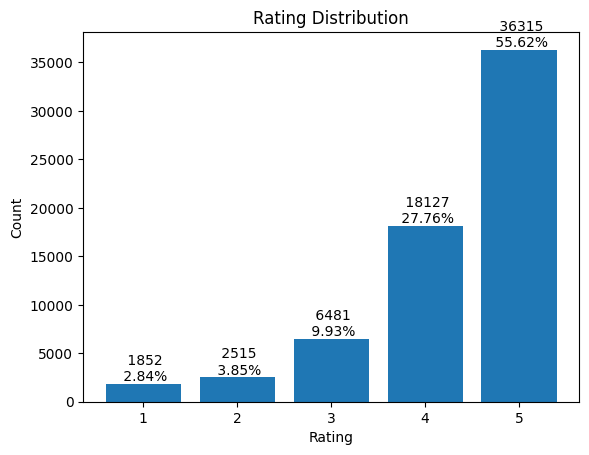

In [17]:
# Count the number of ratings in each category
rating_counts = df['rating'].value_counts()

# Sort the ratings in ascending order
rating_counts = rating_counts.sort_index()

# Calculate the total number of ratings
total_ratings = rating_counts.sum()

# Create the bar plot
plt.bar(rating_counts.index, rating_counts.values)

# Add labels to each bar
for index, count in enumerate(rating_counts):
    percentage = count / total_ratings * 100
    plt.text(index + 1, count + 5, f' {count}\n {percentage:.2f}%',
             ha='center', va='bottom')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')

# Display the plot
plt.show()

####**OBSERVATIONS:**
1. 71,0k rates with the highest score (5), corresponding to 56% of the filtered songs dataset.
2. 32,3k rates with 4-qualification, corresponding to 26%.
3. 18% of the rates are 3 or less.
4. Rating variable distribution seems to be left skewed, which is a **clear bias to higher values** due to biased sampling( ) .

### **Checking the number of unique users and items in the dataset**

In [18]:
# Number of total rows in the data and number of unique user id and product id in the data

# Check the number of total rows in the data
total_rows = len(df)

# Check the number of unique user IDs
unique_user_ids = df['user_id'].nunique()

# Check the number of unique product IDs
unique_product_ids = df['prod_id'].nunique()

print('Total rows:', total_rows)
print('Unique user IDs:', unique_user_ids)
print('Unique product IDs:', unique_product_ids)

Total rows: 65290
Unique user IDs: 1540
Unique product IDs: 5689


####**OBSERVATIONS:**
1. -126k rows of data.
2. +1,5k unique users.
3. +48k unique products.


### **Users with the most number of ratings**

In [19]:
# Top 10 users based on the number of ratings

# Count the number of ratings for each user
user_ratings_count = df['user_id'].value_counts()

# Get the top 10 users with the most ratings
top_10_users = user_ratings_count.head(10)

# Print the top 10 users
print('Top 10 users based on the number of ratings:')
print(top_10_users)

Top 10 users based on the number of ratings:
3512451    295
2989526    230
755206     217
2424036    212
1277963    203
3284634    196
950704     193
1186114    193
4100926    184
3613568    179
Name: user_id, dtype: int64


In [20]:
df['user_id'].value_counts().tail(10)

2040687    4
270420     4
846733     3
1502192    3
1703689    3
199984     2
1467615    2
2640947    1
3866015    1
2926248    1
Name: user_id, dtype: int64

####**OBSERVATIONS:**
1. User with maximum rates has 520 products rated.
2. There are losts of users with 50 product rated.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [21]:
#1. Calculate the average rating for each product
avg_rating = df.groupby('prod_id').mean()['rating']

#2. Calculate the count of ratings for each product
rating_count = df.groupby('prod_id').count()['rating']

#3. Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
                            'Average Rating': avg_rating,
                            'Rating Count': rating_count
                            })

# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values('Average Rating', ascending=False, inplace=True)

# See the first five records of the "final_rating" dataset
print(final_rating.head())

         Average Rating  Rating Count
prod_id                              
475972              5.0             5
177165              5.0            14
270532              5.0             7
466748              5.0             7
399379              5.0             8


In [22]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(df, n, min_interactions):

    # Finding products with minimum number of rating counts
    recommendations = df[df['Rating Count'] >= min_interactions]

    # Sorting values w.r.t average count
    recommendations = recommendations.sort_values(by='Average Rating', ascending=False)

    return recommendations.index[:n]

In [23]:
# Finding products with minimum number of interactions
top_n_products(final_rating, 10, 100)

Int64Index([178812, 70547, 158900, 327307, 157794, 219326, 332575, 166782,
            332573, 332127],
           dtype='int64', name='prod_id')

In [24]:
# Calculate the average rating for each product
avg_rating = df.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
rating_count = df.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'Average Rating': avg_rating, 'Rating Count': rating_count})

# Sort the dataframe by average rating in descending order
final_rating = final_rating.sort_values('Average Rating', ascending=False)

# See the first five records of the "final_rating" dataset
print(final_rating.head())

         Average Rating  Rating Count
prod_id                              
475972              5.0             5
177165              5.0            14
270532              5.0             7
466748              5.0             7
399379              5.0             8


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [25]:
top_n_products(final_rating, 5, 50)

Int64Index([128493, 178812, 102803, 303607, 76554], dtype='int64', name='prod_id')

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [26]:
top_n_products(final_rating, 5, 100)

Int64Index([178812, 70547, 158900, 327307, 157794], dtype='int64', name='prod_id')

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [27]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

from collections import defaultdict

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [33]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [31]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [34]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0116
Precision:  0.858
Recall:  0.822
F_1 score:  0.84


In [ ]:
type(sim_user_user)

**Write your observations here:__________**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", 1400501466, r_ui=2, verbose=True)

**Write your observations here:__________**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
sim_user_user.predict("A3LDPF5FMB782Z", 1000, r_ui=2, verbose=True)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", 1400501466, r_ui=2, verbose=True)

**Write your observations here:__________**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine","msd","pearson","pearson_baseline"],
                              'user_based': [True], "min_support":[2,4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True, "min_support":2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=3, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

**Write your observations here:__________**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", 1400501466, r_ui=2, verbose=True)

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", 1400501466, r_ui=2, verbose=True)

**Write your observations here:**____________

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0,5)

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options

# KNN algorithm is used to find desired similar items. Use random_state=1

# Train the algorithm on the trainset, and predict ratings for the test set

# Let us compute precision@k, recall@k, and f_1 score with k = 10


**Write your observations here:**____________

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product


**Write your observations here:**____________

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product


**Write your observations here:**____________

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters

# Performing 3-fold cross validation to tune the hyperparameters

# Fitting the data

# Find the best RMSE score

# Find the combination of parameters that gave the best RMSE score


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering

# Creating an instance of KNNBasic with optimal hyperparameter values

# Training the algorithm on the trainset

# Let us compute precision@k and recall@k, f1_score and RMSE


**Write your observations here:__________**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"


**Write your observations here:__________**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1

# Training the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE


**Write your observations here:___________**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction


**Write your observations here:___________**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction


**Write your observations here:___________**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune

# Performing 3-fold gridsearch cross-validation

# Fitting data

# Best RMSE score

# Combination of parameters that gave the best RMSE score


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

# Train the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE


**Write your observations here:_____________**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"


### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**